In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


max : 1.000000
min : 0.000000
Skewness: 1.570970
Kurtosis: 1.087887


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


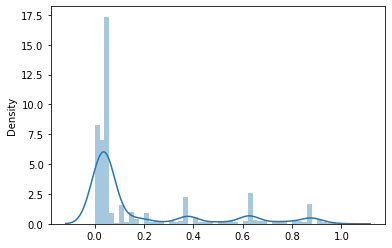

In [9]:
sns.distplot(train[target])

print("max : %f" %train[target].max())
print("min : %f" %train[target].min())
print('Skewness: %f' %train[target].skew())  #歪度
print('Kurtosis: %f' %train[target].kurt())  #尖度

In [10]:
train["cover_log"] = np.log(train['cover']+1)

In [11]:
train["depth_flag"] = 0
train.loc[train["depth"]<=1.0, "depth_flag"] = 1

In [12]:
train["cover_flag"] = 0
train.loc[train["cover"]>.3, "cover_flag"] = 1

In [13]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [14]:
display(train[features])

,MED_H_2013,MED_D678_500_2019,MED_GEMI_2007,MAX_GI,MIN_Alteration_2004,MED_NLI_2018,Date_Acquired,MIN_IF_2009,MIN_AVI_2000,MIN_PSNDc2_2005,...,MIN_IR550_2003,MED_B03,MIN_RDVI_2020,MAX_Chlred_edge_2019,MED_Alteration_2013,MAX_BWDRVI_2006,MAX_CRI550_2008,MIN_CVI_2020,MAX_Cigreen_2016,MED_Red_2004
0,1.552249,-38.700867,-76.875950,22.127987,3.497421,0.264696,20120118.0,2.594846,-29.055183,-0.797719,...,0.020213,454.334839,-2.341663,3.459689,3.937285,-0.807790,-0.017607,0.089984,-0.705697,32.223778
1,1.505057,-22.472477,-346.717304,1.523961,NaN,0.978440,20090706.0,NaN,NaN,-0.740934,...,NaN,1434.901855,-3.282602,0.981658,4.931440,-0.898490,-0.005166,0.093067,-0.128502,NaN
2,1.538269,-38.288010,-226.257012,1.284662,3.416276,0.856527,20091229.0,2.949804,-19.701978,-0.753399,...,0.005089,1847.637329,-3.160207,2.295495,4.365407,-0.938031,-0.006138,0.050589,-0.392834,70.261099
3,1.554473,-56.597656,NaN,2.692885,NaN,0.642540,NaN,NaN,NaN,NaN,...,NaN,1087.847534,-2.373051,3.799269,4.419395,NaN,NaN,0.043962,-0.829977,NaN
4,1.561162,-79.914343,NaN,5.244229,NaN,0.574901,20081210.0,NaN,NaN,NaN,...,NaN,1161.812622,-2.095053,3.456764,4.233529,-0.972951,NaN,0.034838,-0.394863,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,1.549435,-38.152224,-54.470303,1.770164,3.900105,0.891963,20120118.0,2.274326,-10.320679,-0.665999,...,0.028962,485.621185,-1.458936,2.202857,4.223889,-0.938943,-0.013011,0.159633,-0.279369,28.185586
14136,1.549068,-54.544429,NaN,2.992689,NaN,0.719467,20090706.0,NaN,NaN,NaN,...,NaN,1625.421753,-3.932485,6.422394,4.199602,-0.916181,-0.005603,0.029909,-0.426799,NaN
14137,1.555900,-45.298734,NaN,11.645626,3.458194,0.296553,NaN,2.659188,-27.741665,-0.702452,...,NaN,809.198547,-2.470451,3.667547,4.048748,-0.973770,-0.011172,0.053268,-0.524711,16.024178
14138,1.476791,-35.856651,NaN,1.990687,NaN,0.852724,NaN,NaN,NaN,NaN,...,NaN,3101.164551,-4.530392,2.721194,5.346872,-0.966676,NaN,0.139232,-0.666749,NaN


In [15]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [16]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [17]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [18]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [19]:
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [21]:
class CFG:
  ver=10
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="cover_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="cover_flag"
  fold_target2="cover_log"
  fold_target3="cover_log"

In [22]:
# =========================================================================================
# CV split
# =========================================================================================
target_bins = [-1, .3, .5, 1]
target_bin_name = ['0-0.3', '0.3-0.5', '0.5-']
train["target_bins"] = pd.cut(train[target].cover, bins=target_bins, labels=target_bin_name)
bins_map = {'0-0.3':0,  '0.3-0.5':1, '0.5-':2}
train["bins"] = train["target_bins"].map(bins_map)

def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = GroupKFold(n_splits=CFG.n_folds)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target],groups=df["mesh20"])):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [23]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [24]:
features = list(features)
features.remove('id')

In [25]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [26]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
      test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  return oof_df,  test_preds

fold
0    3535
1    3535
2    3535
3    3535
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.155241


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8701456310679612
Precision Score : 0.8765281173594132
Recall Score 0.863855421686747
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.139629


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8771289537712895
Precision Score : 0.8857493857493858
Recall Score 0.8686746987951808
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.156599


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8632740649908033
Precision Score : 0.8789013732833958
Recall Score 0.8481927710843373
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.142853


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8766437069505322
Precision Score : 0.9138381201044387
Recall Score 0.8423586040914561


,feature,importance
3044,depth,0.011086
2526,sst_ymd,0.010565
696,month,0.007143
2969,fetch,0.005952
187,area,0.005283
1497,hist_warm_sst,0.004985
2259,Salinity_annual,0.004911
2262,MIN_GARI,0.004390
1215,warm_sst,0.004241
756,MED_WVP,0.004018


F1 Score : 0.8717791411042946
Precision Score : 0.888402625820569
Recall Score 0.8557663354411322


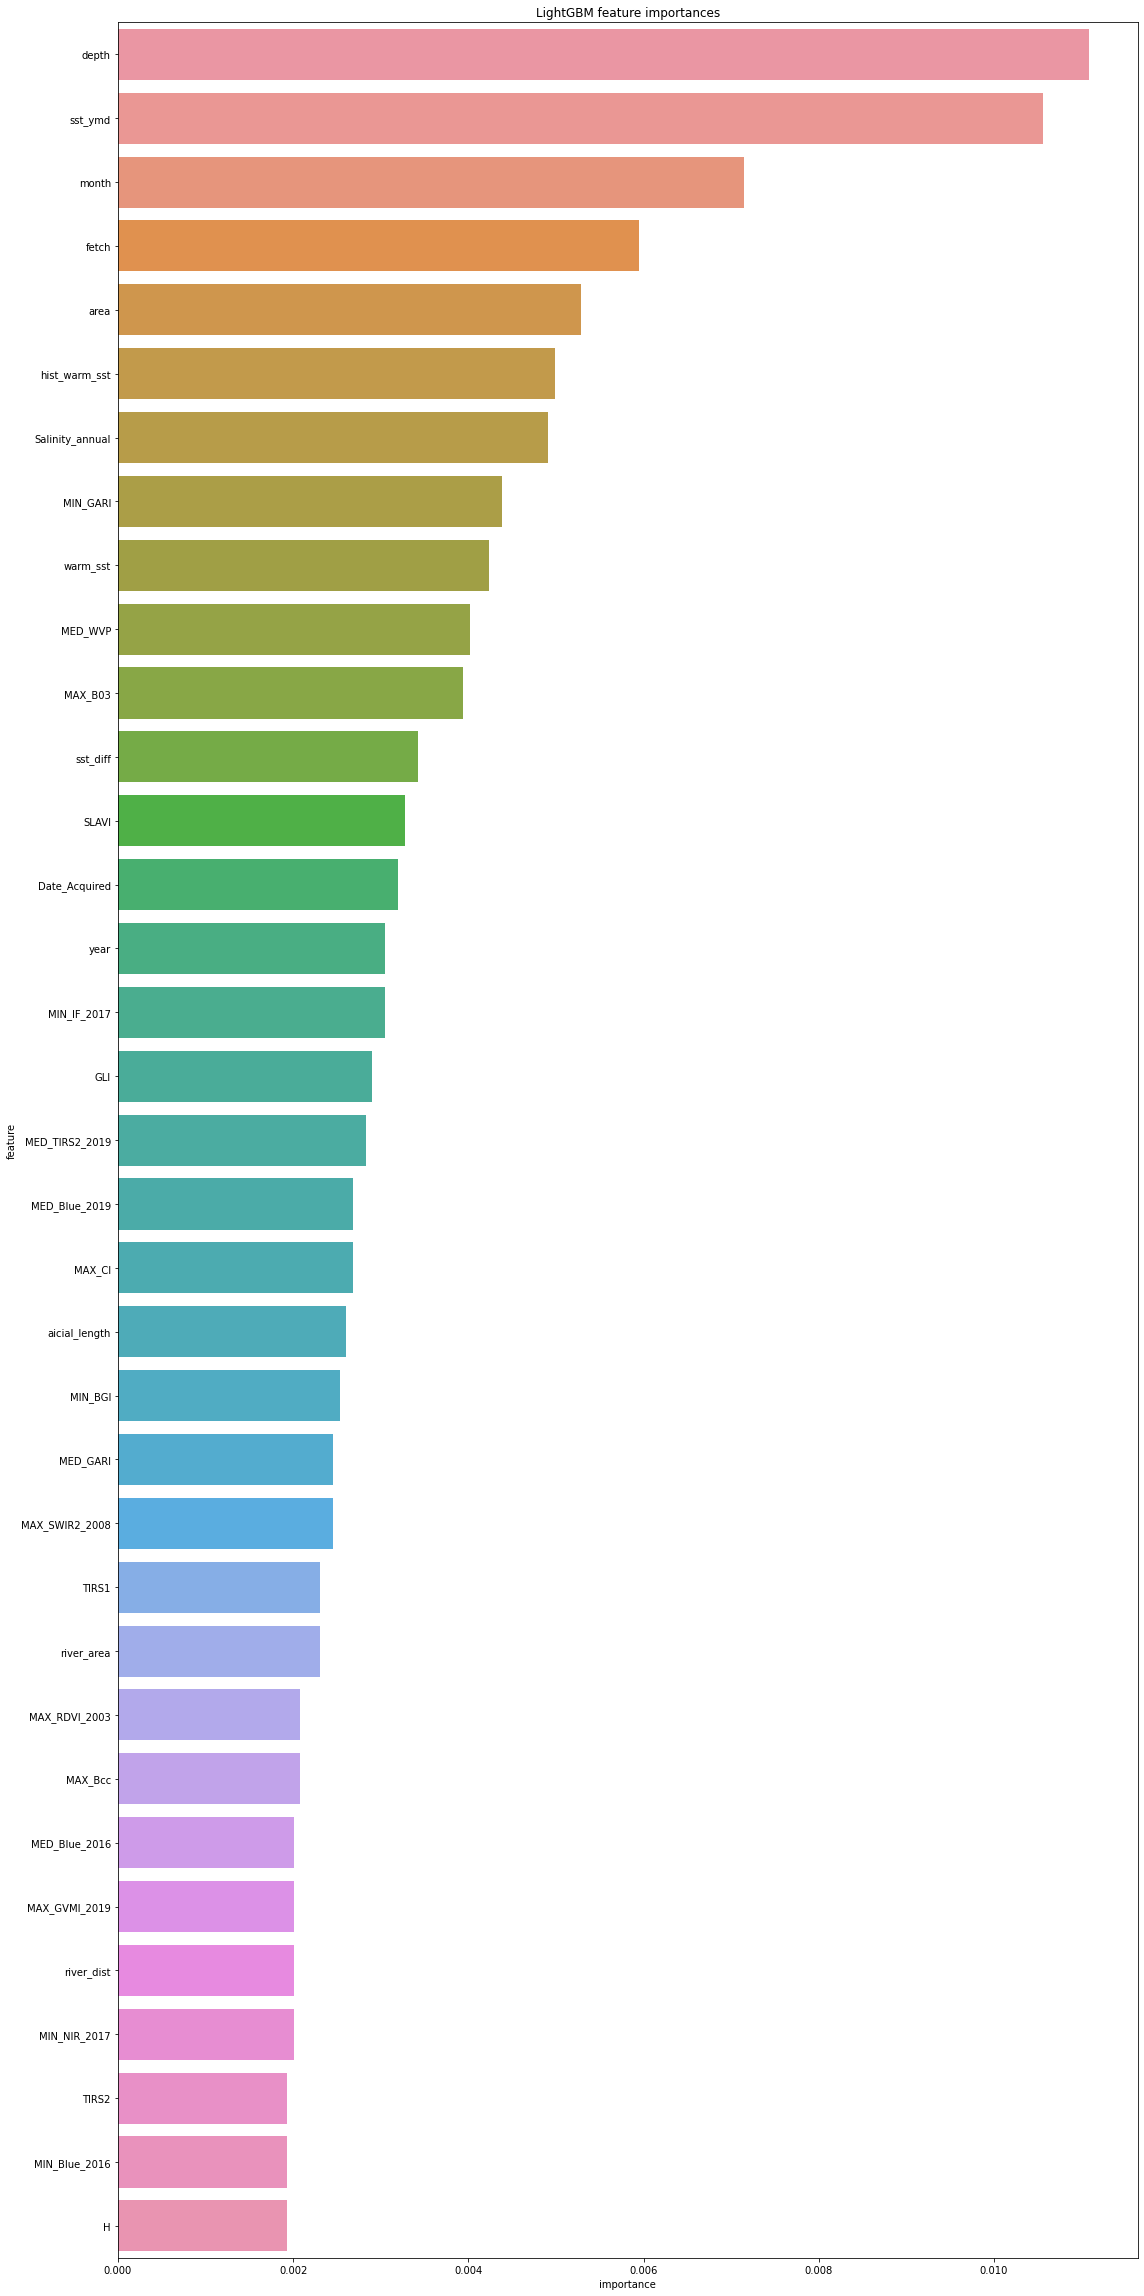

In [27]:
model1 = lgb.LGBMClassifier(**params1)
flag_oof, flag_test_pred = get_pred(train, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [28]:
flag_oof["flag_state"] = (flag_oof["flag_pred"]>.5).astype(int)
test["flag_state"] = (np.mean(flag_test_pred, axis=1)>.5).astype(int)

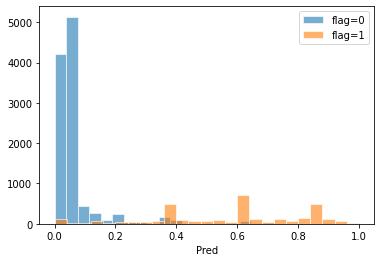

In [29]:
plt.hist(flag_oof.loc[flag_oof.flag_state==0]["cover"], label='flag=0', bins=25, edgecolor='white', alpha=.6)
plt.hist(flag_oof.loc[flag_oof.flag_state==1]["cover"], label='flag=1', bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [30]:
big_train = flag_oof.loc[flag_oof.flag_state==1].reset_index(drop=True)
big_test = test.loc[test.flag_state==1]
print(big_train.shape, big_test.shape)

small_train = flag_oof.loc[flag_oof.flag_state==0].reset_index(drop=True)
small_test = test.loc[test.flag_state==0]
print(small_train.shape, small_test.shape)

(3199, 3475) (348, 3467)
(10941, 3475) (3691, 3467)


fold
0    918
1    761
2    760
3    760
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.226664
RMSE 0.22666399765766201
===============  FOLD : 1  ===============


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.26042
RMSE 0.26041968475212796
===============  FOLD : 2  ===============


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[49]	valid_0's rmse: 0.254955
RMSE 0.2549548856967456
===============  FOLD : 3  ===============


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[35]	valid_0's rmse: 0.206591
RMSE 0.20659059379083078


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


,feature,importance
2810,MAX_Blue_2020,0.011111
696,month,0.007407
41,MED_TIRS2_2015,0.005185
275,MAX_TIRS2_2015,0.005185
2729,MAX_CI,0.004815
2000,MED_mSR,0.004444
550,Red,0.004444
2476,MED_MNSI,0.004444
3138,MED_VARIgreen_2018,0.004444
2569,Blue,0.004444


RMSE 0.2376105182190493


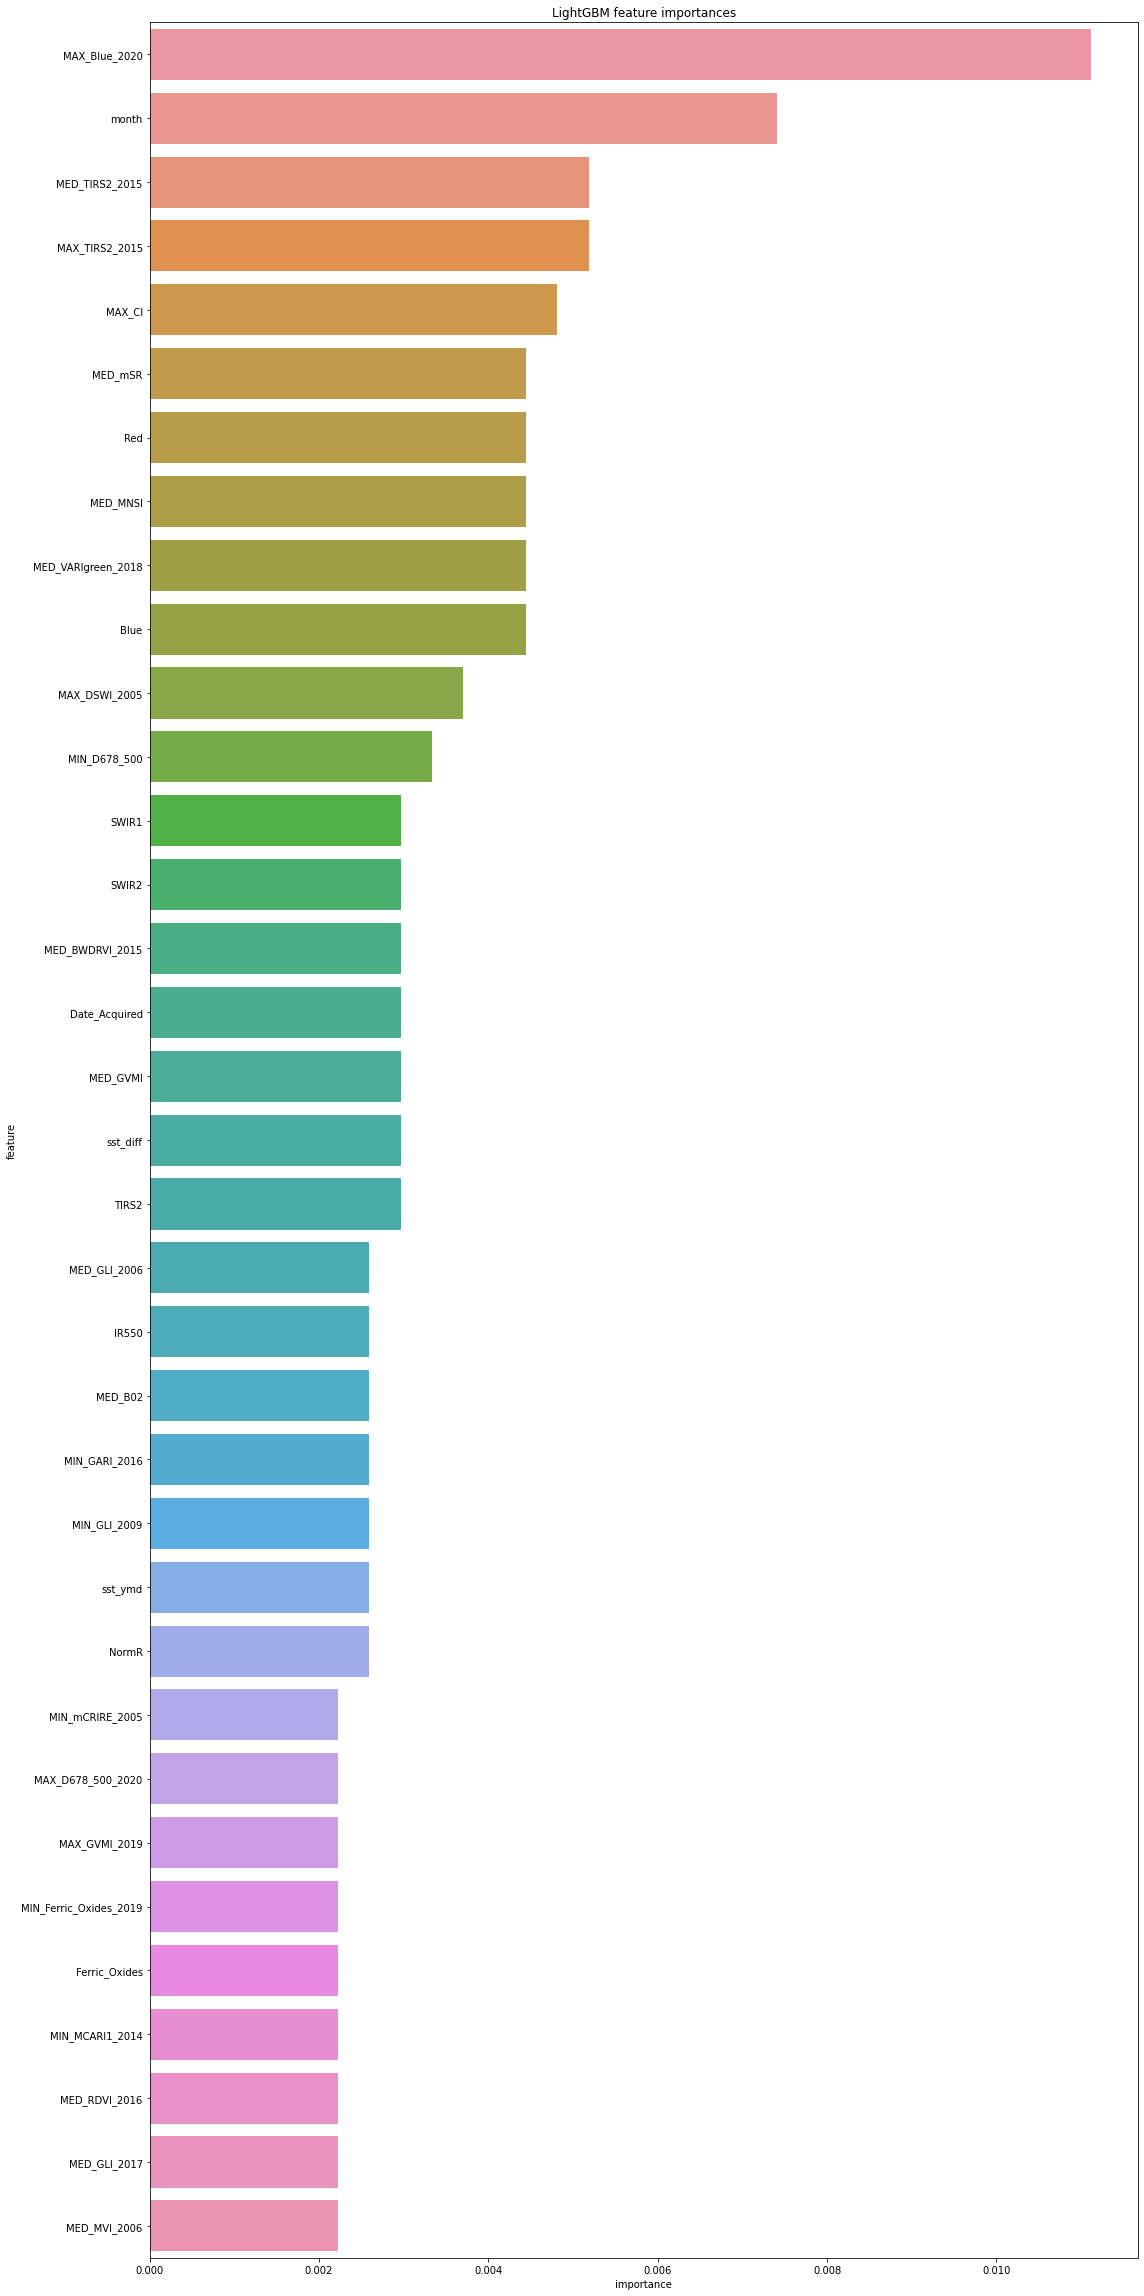

In [31]:
model2 = lgb.LGBMRegressor(**params2)
big_oof, big_test_pred = get_pred(big_train, big_test, CFG.fold_target3, CFG.target_cols2, model2)

fold
0    2739
1    2736
2    2734
3    2732
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.109489


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.10948917416972795
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.100086


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.10008586735768772
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0857652


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.08576523285331131
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.109781


<ipython-input-26-5820d0f1dec2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.10978114423187305


,feature,importance
2960,year,0.023810
6,Date_Acquired,0.019048
1215,warm_sst,0.015238
696,month,0.012381
1872,MED_IF_2013,0.010476
2969,fetch,0.010476
928,river_dist,0.010476
2526,sst_ymd,0.008571
1037,MIN_GLI_2020,0.007619
1201,lat,0.007619


RMSE 0.10175231615547106


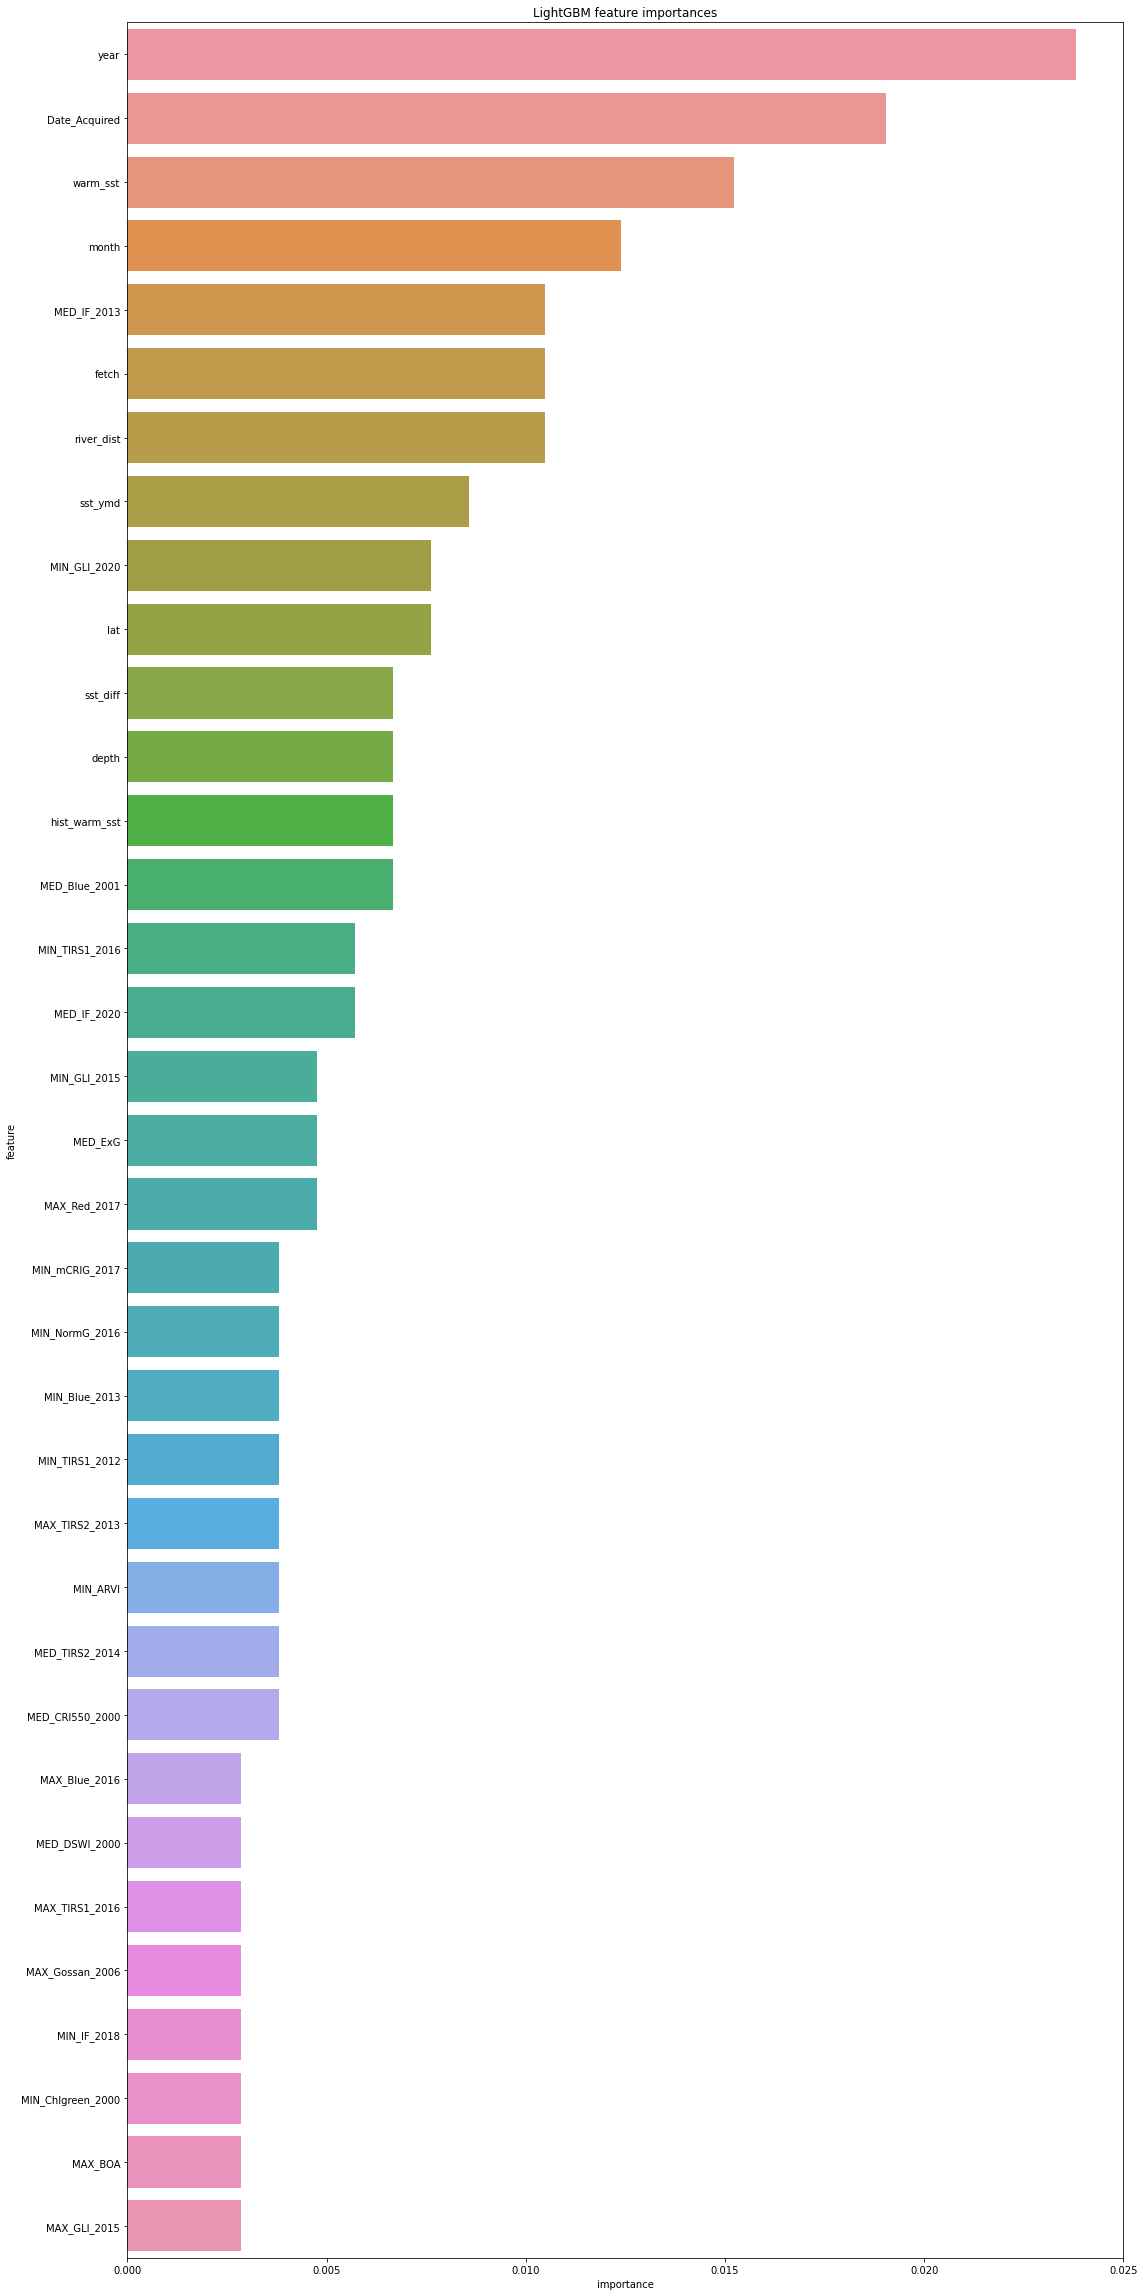

In [32]:
small_oof, small_test_pred = get_pred(small_train, small_test, CFG.fold_target2, CFG.target_cols2, model2)

In [33]:
_oof = pd.concat([big_oof,small_oof])
_oof["pred"] = np.exp(_oof["_pred"]) - 1 
get_score(_oof["cover"], _oof["pred"])

RMSE 0.1677091630803236


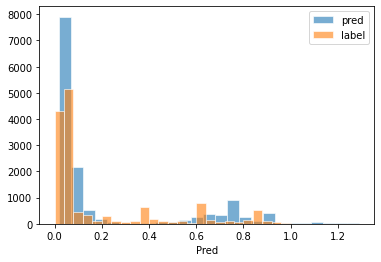

In [34]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [35]:
big_test["pred"] = np.mean(big_test_pred, axis=1)
small_test["pred"] = np.mean(small_test_pred, axis=1)

pred_df = pd.concat([big_test,small_test])
pred_df["pred"] = np.exp(pred_df["pred"]) - 1 
pred_df = pred_df.sort_index()
pred_df

<ipython-input-35-c20223a4ed06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_test["pred"] = np.mean(big_test_pred, axis=1)
<ipython-input-35-c20223a4ed06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_test["pred"] = np.mean(small_test_pred, axis=1)


,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,mesh20_left,mesh20_right,flag_state,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,3624,20,0,0.088130
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,3624,20,0,0.094317
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,3927,23,0,0.058476
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,3927,11,0,0.059949
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,3725,1,0,0.111722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,4027,3,0,0.089062
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,3624,20,0,0.061735
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,3927,23,1,0.751052
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,3623,3,0,0.088210


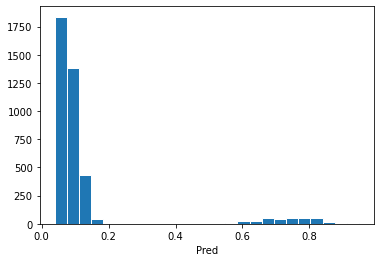

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,mesh20_left,mesh20_right,flag_state,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,3624,20,0,0.088130
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,3624,20,0,0.094317
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,3927,23,0,0.058476
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,3927,11,0,0.059949
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,3725,1,0,0.111722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,4027,3,0,0.089062
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,3624,20,0,0.061735
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,3927,23,1,0.751052
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,3623,3,0,0.088210


In [36]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)